# Introduction
This notebook gives an example of how to work with the provided training data and utils.

If you want to learn more about the different voltage levels in Europe you can find an article [here](https://www.axpo.com/ch/de/ueber-uns/magazin.detail.html/magazin/energiemarkt/der-weg-des-stroms.html) (unfortunately only available in German but google translate might help you out).

## To get a better feeling for our problem, let's plot some data
The reward or penalty we get in a substation for following the target voltage is dependent on the deviation of the currently measured voltage $V_m$ from the target voltage $V_t$ and the reactive power. The point system we use is a simplification of the reward system for voltage support. The dependance on the reactive power can be simplified by assuming capacitive behavior if the shunt reactor is turned off and inductive behavior if it is turned on.

In [25]:
%load_ext autoreload
%autoreload 2

# plot the reward function with plotly as line plot
import plotly.io as pio
import numpy as np
import plotly.graph_objs as go
from plotly.subplots import make_subplots

from utils import eval

pio.renderers.default = 'iframe'

dV = np.arange(-2.5, 2.5, 0.001)

# plot the reward function using plotly
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.05)
fig.add_trace(go.Scatter(x=dV, y=eval.reward_function(dV, np.ones(dV.shape, dtype=bool)), name='Reactor On'), row=1, col=1)
fig.add_trace(go.Scatter(x=dV, y=eval.reward_function(dV, ~np.ones(dV.shape, dtype=bool)), name='Reactor Off'), row=2, col=1)
fig.update_layout(title='Reward/Penalty per 15min')
fig.update_xaxes(title_text='\u0394V', row=2, col=1)
fig.update_yaxes(title_text='Reward', row=2, col=1)
fig.update_yaxes(title_text='Reward', row=1, col=1)
fig.show()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Total Reward
Let's calculate the financial reward for the timeseries of voltage deviations over a one hour timespan. We will have a look at two different scenarios of operating the shunt reactor and see their impact on our reward. A shunt reactor state of `True` means it is turned on and should lower the voltage.

In [26]:
dV = np.array([0.2, -0.9, -2.1, 0.])
shunt_reactor_states = np.array([True, True, False, False])
reward_weighing_factors = np.linspace(1, 0.8, 4)

# make a plot with three lines for dV, shunt_reactor_states and weighing_factors
fig = make_subplots(rows=3, cols=1, shared_xaxes=True, vertical_spacing=0.05)
fig.add_trace(go.Scatter(x=np.arange(dV.shape[0])/4, y=dV, name='\u0394V'), row=1, col=1)
fig.add_trace(go.Scatter(x=np.arange(shunt_reactor_states.shape[0])/4, y=shunt_reactor_states, name='Shunt Reactor States Scenario 1'), row=2, col=1)
fig.add_trace(go.Scatter(x=np.arange(shunt_reactor_states.shape[0])/4, y=~shunt_reactor_states, name='Shunt Reactor States Scenario 2'), row=2, col=1)
fig.add_trace(go.Scatter(x=np.arange(reward_weighing_factors.shape[0])/4, y=reward_weighing_factors, name='Weighing Factors'), row=3, col=1)
fig.update_layout(title='Reward/Penalty per 15min')
fig.update_xaxes(title_text='Time', row=3, col=1)
fig.update_yaxes(title_text='\u0394V', row=1, col=1)
fig.update_yaxes(title_text='States', row=2, col=1)
fig.update_yaxes(title_text='Reward Weighing', row=3, col=1)
fig.show()

print(f"The total reward for the plotted time in scenario 1 is {eval.reward_sum(dV, shunt_reactor_states, weighing_factors=reward_weighing_factors)}.")
print(f"The total reward for the plotted time in scenario 2 is {eval.reward_sum(dV, ~shunt_reactor_states, weighing_factors=reward_weighing_factors)}.")

The total reward for the plotted time in scenario 1 is 10.8.
The total reward for the plotted time in scenario 2 is -12.946666666666664.


# Historical Target vs. Real Voltage
Let's plot the target and real voltage for both of the substations in the year 2022. The target voltage is the the one ending with `SOL`, while the real voltage is the one ending with `IST`. If you speak German, this will make sense, if not, you can probably remember it nevertheless. The `Reactive Power` of the shunt reactor can be seen in the lower plot. It is zero if the shunt reactor is turned off and controlled between 35Mvar and 90Mvar if it is on.

In [27]:
from utils import feature_eng, visualization

station_b_train = feature_eng.get_data_df("train", "B")

visualization.plot_substation_measurements(station_b_train, "B")

In [28]:
station_a_train = feature_eng.get_data_df("train", "A")

visualization.plot_substation_measurements(station_a_train, "A")

We can see that there is a clear seasonal effect in the measured voltage. Especially during Summer, the Voltage tends to be too high. Furthermore, station A is not particularly interesting in that the voltage is almost always too high.

# Electricity Production
Let's also plot the electricity production in Germany and Switzerland for the same period. Note that only for solar and wind production there are publicly available forecasts. We provided you with the other types of production to check out if they could be useful. However, using them for Voltage forecasts in practice might turn out challenging.

In [29]:
# Create a list of traces for each column
columns2plot = [
    'CH Solar [MW]',
    'CH Hydro Pumped Storage [MW]',
    'CH Hydro Run-of-river and poundage [MW]',
]
visualization.plot_production(station_b_train, columns2plot, title='Production in Switzerland')

Let's also plot German Solar and Wind production. These probably have the biggest influence on the voltage in our substations.

In [30]:
# Create a list of traces for each column
columns2plot = [
    'DE Solar [MW]',
    'DE Wind Onshore [MW]',
]
visualization.plot_production(station_b_train, columns2plot, title='Production in Germany')

# Training a Model
Let's start by training a simple model. For now, we will ignore the canundrum of impacting the system with our decision of turning the shunt reactor on or off. Addidtionally, we only use features that are known in advance (time, whether it's a holiday) or of which there are sufficiently reliable forecasts for the next 24 hours. That way our super simple first model can simply be a regression instead of a specific time series model.

In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

station_b_train = feature_eng.add_temporal_features(station_b_train)

feature_columns = [
    'hour_sin',
    'hour_cos',
    'holiday',
    # 'CH Solar [MW]', # there are good open source forecasts for solar and wind production, for other production types there are none openly available
    'Longwave Radiation',
    'Temperature [2 m elevation corrected]',
    'ZLQZLQSPHSDL_VNUUSOL',
]
X_train = station_b_train[feature_columns].values
y_train = station_b_train['ZLQZLQSPHSDL_VNUUIST'].values
pipe = make_pipeline(StandardScaler(), LinearRegression())
pipe.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [32]:
# Let's make a prediction for our validation data
from sklearn.metrics import mean_squared_error

station_b_val = feature_eng.add_temporal_features(feature_eng.get_data_df("val", "B"))

X_val = station_b_val[feature_columns].values
y_val = station_b_val['ZLQZLQSPHSDL_VNUUIST'].values

y_pred = pipe.predict(X_val)

print('Mean square error for the validation data:', mean_squared_error(y_val, y_pred))

Mean square error for the validation data: 0.6545706243114798


In [33]:
fig = visualization.plot_substation_measurements(station_b_val, "B")
station_b_val['VNUUIST_prediction'] = y_pred
fig.add_trace(go.Scatter(x=station_b_val.index, y=station_b_val['VNUUIST_prediction'], name='VNUUIST_prediction'), row=1, col=1)
fig.show()

### Benchmarking
Let's how our model would have performed compared to an ex-post decision of turning the shunt reactor on or off.

In [34]:
pars = {
    'B': {
        'sensitivity': 0.0454, # [kV/MVar]
        'reactive_power_min': 35.0, # [MVar]
        'reactive_power_max': 90.0, # [MVar]
    },
    'A': {
        'sensitivity': 0.0277, # [kV/MVar]
        'reactive_power_min': 35.0, # [MVar]
        'reactive_power_max': 90.0, # [MVar]
    }
}

In [35]:
import pandas as pd

# calculate reward points achieved for the validation dataset
reward_base = eval.reward_sum(
    station_b_val["ZLQZLQSPHSDL_VNUUIST"].values - station_b_val["ZLQZLQSPHSDL_VNUUSOL"].values, 
    (station_b_val['ZLQZLQ110KOMDROQ'] > 1.0).values, 
    weighing_factors=np.ones(station_b_val.shape[0]))
print(f'Reward achieved by operating the shunt reactor as in the validation dataset: {reward_base}.')

# Additional reward points with theoretical optimal switching strategy
# and the theoretical voltage calculated with a system linearization.
station_b_val['dV'] = station_b_val["ZLQZLQSPHSDL_VNUUIST"] - station_b_val["ZLQZLQSPHSDL_VNUUSOL"]
station_b_val[['points_realized', 'virtual_points_maximal', 'virtual_dV_opt', 'virtual_WQ_opt']] = \
    station_b_val.apply(lambda row: pd.Series(eval.maximize_virtual_points(row['dV'], row['ZLQZLQ110KOMDROQ'], pars['B']['sensitivity'])), axis=1)
virtual_optimal_additional_reward = (station_b_val['virtual_points_maximal'] - station_b_val['points_realized']).sum()
print(f'Extra reaward points with theoretical optimal switching strategy: {virtual_optimal_additional_reward}.')

Reward achieved by operating the shunt reactor as in the validation dataset: 25728.0.
Extra reaward points with theoretical optimal switching strategy: 171.0.


In [36]:
# How many points would our prediction achieve?
# TODO: make a function that only calculates the would have been points
station_b_val['dV_pred'] = station_b_val["VNUUIST_prediction"] - station_b_val["ZLQZLQSPHSDL_VNUUSOL"]
station_b_val[['virtual_realized_reward', 'virtual_optimal_reward', 'virtual_optimal_WQ']] = \
    station_b_val.apply(lambda row: pd.Series(eval.alternative_strategy_reward(row['dV'], row['dV_pred'], row['ZLQZLQ110KOMDROQ'], pars['B']['sensitivity'])), axis=1)
model_virtual_additional_reward = (station_b_val['virtual_realized_reward'] - station_b_val['points_realized']).sum()
print(f'Extra reward points with a switching strategy based on our voltage prediction: {model_virtual_additional_reward}.')

Extra reward points with a switching strategy based on our voltage prediction: 3.0.


# Next Steps for You
As you see, there is definitely room for improvement when considering what is theoretically possible and what our simple model achieved. There are several things you might want to look at before you jump into training a model to predict voltages:
- The correlation (matrix) of different features at the same point in time, as well as with future values of the voltage. For example, the voltage at t0 is highly correlated with the voltage at t0+15min. How do different weather and energy production impact voltages?
- How will you deal with the feedback effect of the shunt reactor on the system. Whether you turn it off or on will impact the voltage that will be present in the system. Additionally, this has also led to a bias in the training and validation data. The shunt reactor, in general, was turned off when the voltage was too low and on elsewise. 
- If you use a non-linear model, you might want to try to predict the deviation of the measured voltage from the target voltage (VNUUIST - VNUUSOL) instead of the absolute of the measured voltage.

In [37]:
station_b_val.columns.unique()

Index(['ZLQPRQ220TR_22+Q', 'ZLQPRQ220TR_21+Q', 'ZLQPRU220TR_21+P',
       'ZLQPRQ220TR_21+P', 'ZLQPRQ220TR_22+P', 'ZLQPRU220TR_21+Q',
       'ZLQZLQ220TR_21+P', 'ZLQZLQ220TR_21+Q', 'ZLQZLQ220SS_1++U_L12',
       'ZLQZLQ220SS_2++U_L12', 'ZLQZLQ110KOMDROQ', 'ZLQZLQ220TR_22+Q',
       'ZLQZLQ220TR_22+P', 'ZLQZLQSPHSDL_VNUUIST', 'ZLQZLQSPHSDL_VNUUSOL',
       'CH Biomass [MW]', 'CH Fossil Brown coal/Lignite [MW]',
       'CH Fossil Coal-derived gas [MW]', 'CH Fossil Gas [MW]',
       'CH Fossil Hard coal [MW]', 'CH Fossil Oil [MW]',
       'CH Fossil Oil shale [MW]', 'CH Fossil Peat [MW]', 'CH Geothermal [MW]',
       'CH Hydro Pumped Storage [MW]',
       'CH Hydro Pumped Storage  - Actual Consumption [MW]',
       'CH Hydro Run-of-river and poundage [MW]',
       'CH Hydro Water Reservoir [MW]', 'CH Marine [MW]', 'CH Nuclear [MW]',
       'CH Other [MW]', 'CH Other renewable [MW]', 'CH Solar [MW]',
       'CH Waste [MW]', 'CH Wind Offshore [MW]', 'CH Wind Onshore [MW]',
       'DE Biomas

In [38]:
station_b_train.columns.unique()

Index(['ZLQPRQ220TR_22+P', 'ZLQPRQ220TR_21+Q', 'ZLQPRQ220TR_22+Q',
       'ZLQPRU220TR_21+P', 'ZLQPRQ220TR_21+P', 'ZLQPRU220TR_21+Q',
       'ZLQZLQ220TR_21+Q', 'ZLQZLQ220TR_22+P', 'ZLQZLQ220TR_21+P',
       'ZLQZLQ220SS_1++U_L12', 'ZLQZLQSPHSDL_VNUUIST', 'ZLQZLQ220SS_2++U_L12',
       'ZLQZLQSPHSDL_VNUUSOL', 'ZLQZLQ110KOMDROQ', 'ZLQZLQ220TR_22+Q',
       'CH Biomass [MW]', 'CH Fossil Brown coal/Lignite [MW]',
       'CH Fossil Coal-derived gas [MW]', 'CH Fossil Gas [MW]',
       'CH Fossil Hard coal [MW]', 'CH Fossil Oil [MW]',
       'CH Fossil Oil shale [MW]', 'CH Fossil Peat [MW]', 'CH Geothermal [MW]',
       'CH Hydro Pumped Storage [MW]',
       'CH Hydro Pumped Storage  - Actual Consumption [MW]',
       'CH Hydro Run-of-river and poundage [MW]',
       'CH Hydro Water Reservoir [MW]', 'CH Marine [MW]', 'CH Nuclear [MW]',
       'CH Other [MW]', 'CH Other renewable [MW]', 'CH Solar [MW]',
       'CH Waste [MW]', 'CH Wind Offshore [MW]', 'CH Wind Onshore [MW]',
       'DE Biomas

In [39]:
station_a_train.columns.unique()

Index(['EUHIDO220TR_21+P', 'EUHIDO110KOMDROQ', 'EUHIDO220SS_1++U_L31',
       'EUHIDO220SS_2A+U_L31', 'EUHIDO220TR_21+Q', 'EUHIDO220TR_22+P',
       'EUHWRH220TR_21+P', 'EUHWRH220TR_21+Q', 'EUHIDOSPHSDL_VNUUIST',
       'EUHIDOSPHSDL_VNUUSOL', 'JU\DDW220TR_21+Q', 'JU\DDW220TR_22+Q',
       'JU\DDW220TR_21+P', 'JU\DDW220TR_22+P', 'EUHIDO220TR_22+Q',
       'EUHWRH220TR_22+P', 'EUHWRH220TR_22+Q', 'CH Biomass [MW]',
       'CH Fossil Brown coal/Lignite [MW]', 'CH Fossil Coal-derived gas [MW]',
       'CH Fossil Gas [MW]', 'CH Fossil Hard coal [MW]', 'CH Fossil Oil [MW]',
       'CH Fossil Oil shale [MW]', 'CH Fossil Peat [MW]', 'CH Geothermal [MW]',
       'CH Hydro Pumped Storage [MW]',
       'CH Hydro Pumped Storage  - Actual Consumption [MW]',
       'CH Hydro Run-of-river and poundage [MW]',
       'CH Hydro Water Reservoir [MW]', 'CH Marine [MW]', 'CH Nuclear [MW]',
       'CH Other [MW]', 'CH Other renewable [MW]', 'CH Solar [MW]',
       'CH Waste [MW]', 'CH Wind Offshore [MW]', '

In [41]:
import cvxpy as cp
import numpy as np

# Optimization problem with one DeltaV only. Taking the worst case dV could be a simplified solution
# the decision variable a decides when to switch on or off the shunt
# The caviat of it is that the penalty is sized with the dV the way the obj is defined. Another way must be found to normalize it
# but see commented obj below --> if normalized in the objective function, problem becomes infeasible

# Construct the problem.

dv1 = station_b_val["VNUUIST_prediction"] - station_b_val["ZLQZLQSPHSDL_VNUUSOL"]
dv1 = dv1[50*96:53*96].to_numpy()
a = cp.Variable(dv1.shape[0], integer=True)

# dv1 = np.array([-2, -3, -5, -3, -1, 0, 2, 5, 3])
# dv2 = np.array([-1,  0, -2,  3,  2, 4, 2, 1, 3])


obj = sum(cp.multiply(a,(cp.maximum(0, dv1+1) - 6*(cp.maximum(0, -2-dv1)))) \
      + cp.multiply((1-a), cp.maximum(0, 1-dv1) - 6*(cp.maximum(0, dv1-2))))

#obj = sum(a*(cp.maximum(0, (a*dv1 + (1-a)*dv2) - 1)/((a*dv1 + (1-a)*dv2) - 1) - 6*(cp.maximum(0, (a*dv1 + (1-a)*dv2) + 2)/(a*dv1 + (1-a)*dv2) + 2)) \
#     + (1-a)*(cp.maximum(0, 1-(a*dv1 + (1-a)*dv2))/(1-(a*dv1 + (1-a)*dv2)) - 6*(cp.maximum(0, (a*dv1 + (1-a)*dv2) -2)/(a*dv1 + (1-a)*dv2) -2)))

objective = cp.Maximize(obj)
constraints = [0 <= a, a <= 1, sum(cp.abs(cp.diff(a))) <= 6]
prob = cp.Problem(objective, constraints)

# The optimal objective value is returned by `prob.solve()`.
result = prob.solve()
# The optimal Lagrange multiplier for a constraint is stored in
# `constraint.dual_value`.
print(constraints[0].dual_value)

None


In [23]:
import cvxpy as cp
import numpy as np


# Construct the problem.

dv1 = station_b_val["VNUUIST_prediction"] - station_b_val["ZLQZLQSPHSDL_VNUUSOL"]
dv1 = dv1[50*96:53*96].to_numpy()
x1 = cp.Variable((dv1.shape[0]), integer=True)
x2 = cp.Variable((dv1.shape[0]), integer=True)
x3 = cp.Variable((dv1.shape[0]), integer=True)
x4 = cp.Variable((dv1.shape[0]), integer=True)

# dv1 = np.array([-2, -3, -5, -3, -1, 0, 2, 5, 3])
# dv2 = np.array([-1,  0, -2,  3,  2, 4, 2, 1, 3])


# obj = sum(cp.multiply(a,(cp.maximum(0, dv1+1) - 6*(cp.maximum(0, -2-dv1)))) \
#      + cp.multiply((1-a), cp.maximum(0, 1-dv1) - 6*(cp.maximum(0, dv1-2))))

obj = sum(x1 - 6*x2 + x3 -6*x4)

#obj = sum(a*(cp.maximum(0, (a*dv1 + (1-a)*dv2) - 1)/((a*dv1 + (1-a)*dv2) - 1) - 6*(cp.maximum(0, (a*dv1 + (1-a)*dv2) + 2)/(a*dv1 + (1-a)*dv2) + 2)) \
#     + (1-a)*(cp.maximum(0, 1-(a*dv1 + (1-a)*dv2))/(1-(a*dv1 + (1-a)*dv2)) - 6*(cp.maximum(0, (a*dv1 + (1-a)*dv2) -2)/(a*dv1 + (1-a)*dv2) -2)))

M = cp.Constant(10000)

objective = cp.Maximize(obj)
constraints = [0 <= x1, x1 <= 1,
               0 <= x2, x2 <= 1,
               0 <= x3, x3 <= 1,
               0 <= x4, x4 <= 1,
               M*x1 >= dv1 + 1,
               M*(1-x1) >= -1 - dv1,
               M*x2 >= - dv1 - 2,
               M*(1-x2) >= dv1 + 2,
               M*x3 >= 1 - dv1,
               M*(1-x3) >= dv1 - 1,
               M*x4 >= dv1 - 2,
               M*(1-x4) >= 2 - dv1]

prob = cp.Problem(objective, constraints)

# The optimal objective value is returned by `prob.solve()`.
result = prob.solve()
# The optimal Lagrange multiplier for a constraint is stored in
# `constraint.dual_value`.
print(constraints[0].dual_value)

None


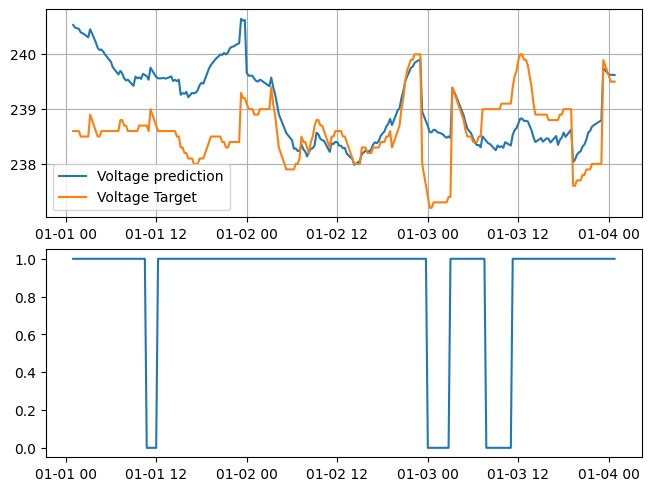

In [42]:
import matplotlib.pyplot as plt


fig, axs = plt.subplots(2, 1, layout='constrained')
axs[0].plot(station_b_val.index[:288], station_b_val["VNUUIST_prediction"][:288], 
            station_b_val.index[:288], station_b_val["ZLQZLQSPHSDL_VNUUSOL"][:288])
axs[0].grid(True)
axs[1].plot(station_b_val.index[:288], a.value)
axs[0].legend(['Voltage prediction', 'Voltage Target'])


